In [117]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [134]:
path = r"/content/drive/MyDrive/datasets - images/brain-scans-tumors"

def load_images(path, size=(150,150)):

  images = []
  labels = []
  classes = os.listdir(path) # folder with the image classes

  for type in classes:
    class_path = os.path.join(path, type)
    print(class_path)

    if not os.path.isdir(class_path):
      continue # if it is not a folder ignore it
      print("flag 1")

    for image in os.listdir(class_path):
      # path to the image
      image_path = os.path.join(class_path, image)

      # convert image to RGB, if it isn't
      image = Image.open(image_path).convert("L") # converts image to grayscale

      # resize image
      image = image.resize(size, Image.Resampling.LANCZOS) # retain image quality when resized

      image = np.array(image) #convert images to numbers

      images.append(image) # a list in a list
      labels.append(type)

  # convert images list to a numpy array
  images = np.array(images)
  labels = np.array(labels)

  return images, labels


X, y = load_images(path)

/content/drive/MyDrive/datasets - images/brain-scans-tumors/no
/content/drive/MyDrive/datasets - images/brain-scans-tumors/yes


In [135]:
print(X.shape)
print(y.shape)

(253, 150, 150)
(253,)


## Positive Case

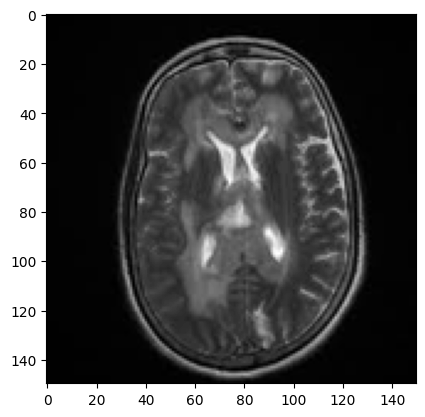

In [136]:
plt.imshow(X[10], cmap="gray")

## Negative Class

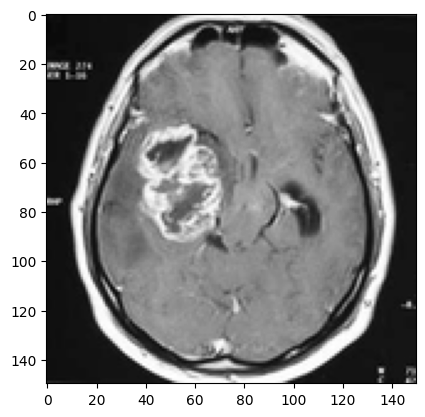

In [137]:
plt.imshow(X[150], cmap="gray")

## Data Preprocessing

### Data Normalization

In [138]:
X = X / 255

### Categorize labels

In [139]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(y)
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

## Split data into training, validation and test set

In [140]:
from sklearn.model_selection import train_test_split
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

X_tmp, X_test, y_tmp, y_test = train_test_split(X, y, test_size=test_ratio, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_tmp, y_tmp, test_size = (train_ratio/(1-test_ratio)), random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(25, 150, 150)
(25,)
(202, 150, 150)
(202,)
(26, 150, 150)
(26,)


## Model Training

In [141]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [142]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(150,150,1), padding='same'),
    Dropout(0.5),
    MaxPooling2D(pool_size=(2,2),strides=2),
    Conv2D(filters=16, kernel_size=(2,2), activation='relu', padding='same'),
    Dropout(0.5),
    MaxPooling2D(pool_size=(2,2),strides=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid') # binary classification
])

In [143]:
opt = tf.keras.optimizers.Adam()
loss = tf.keras.losses.BinaryCrossentropy()

model.compile(
    optimizer = opt,
    loss = loss,
    metrics = ['accuracy']
)

In [144]:
# callbacks
checkpoint_cb = ModelCheckpoint(
    filepath = "/content/drive/MyDrive/model-{epoch:02d}-{val_accuracy:.2f}.hdf5",
    monitor="val_accuracy",
    mode="max",
    save_best_only = True,
    verbose = 1
)


early_stopping_cb = EarlyStopping(
    monitor = "val_accuracy",
    patience = 10,
    mode = "max",
    min_delta = 0.0001,
)

In [145]:
model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val)) #, callbacks=[checkpoint_cb, early_stopping_cb]

Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 0.7389 - accuracy: 0.4000 - val_loss: 0.6352 - val_accuracy: 0.6139
Epoch 2/50
1/1 [==============================] - 2s 2s/step - loss: 0.9061 - accuracy: 0.6000 - val_loss: 0.6888 - val_accuracy: 0.6188
Epoch 3/50
1/1 [==============================] - 2s 2s/step - loss: 0.6440 - accuracy: 0.7200 - val_loss: 0.6791 - val_accuracy: 0.6782
Epoch 4/50
1/1 [==============================] - 2s 2s/step - loss: 0.6040 - accuracy: 0.8000 - val_loss: 0.6396 - val_accuracy: 0.7426
Epoch 5/50
1/1 [==============================] - 3s 3s/step - loss: 0.5091 - accuracy: 0.7600 - val_loss: 0.6160 - val_accuracy: 0.7277
Epoch 6/50
1/1 [==============================] - 4s 4s/step - loss: 0.4796 - accuracy: 0.7600 - val_loss: 0.6057 - val_accuracy: 0.7327
Epoch 7/50
1/1 [==============================] - 2s 2s/step - loss: 0.4246 - accuracy: 0.8000 - val_loss: 0.5973 - val_accuracy: 0.7822
Epoch 8/50
1/1 [=========================

In [146]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 150, 150, 32)      320       
                                                                 
 dropout_8 (Dropout)         (None, 150, 150, 32)      0         
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 75, 75, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_28 (Conv2D)          (None, 75, 75, 16)        2064      
                                                                 
 dropout_9 (Dropout)         (None, 75, 75, 16)        0         
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 37, 37, 16)        0         
 ng2D)                                               

Text(0.5, 1.0, 'Model loss with dropout at 50%')

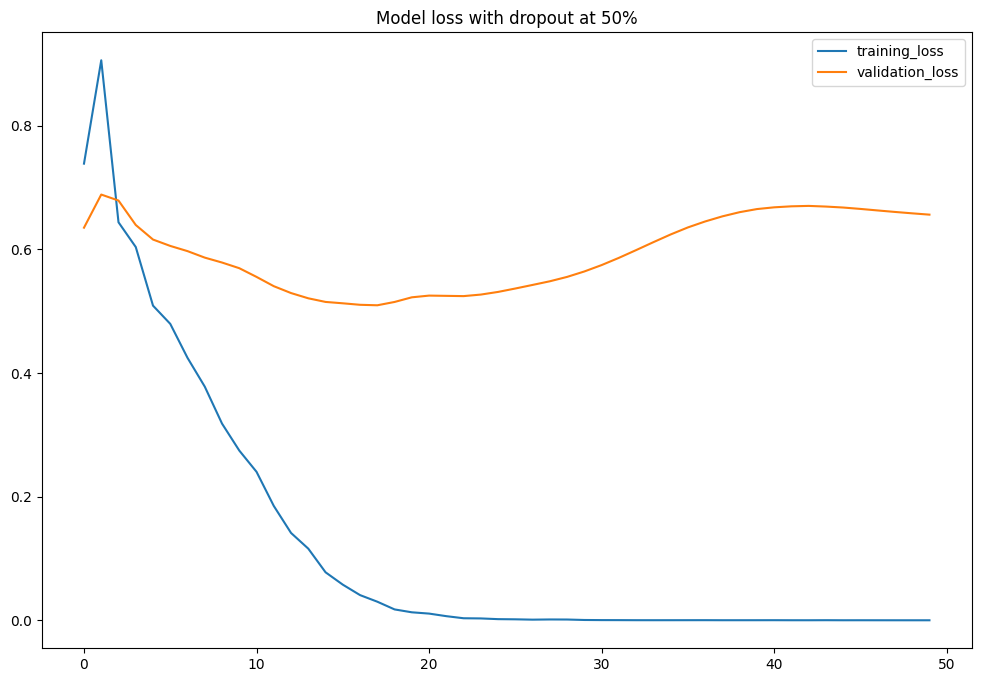

In [147]:
history = model.history.history
history = pd.DataFrame(history)

plt.figure(figsize=(12,8))
plt.plot(history['loss'], label="training_loss")
plt.plot(history['val_loss'], label="validation_loss")
plt.legend()
plt.title("Model loss with dropout at 50%")

<Axes: ylabel='loss'>

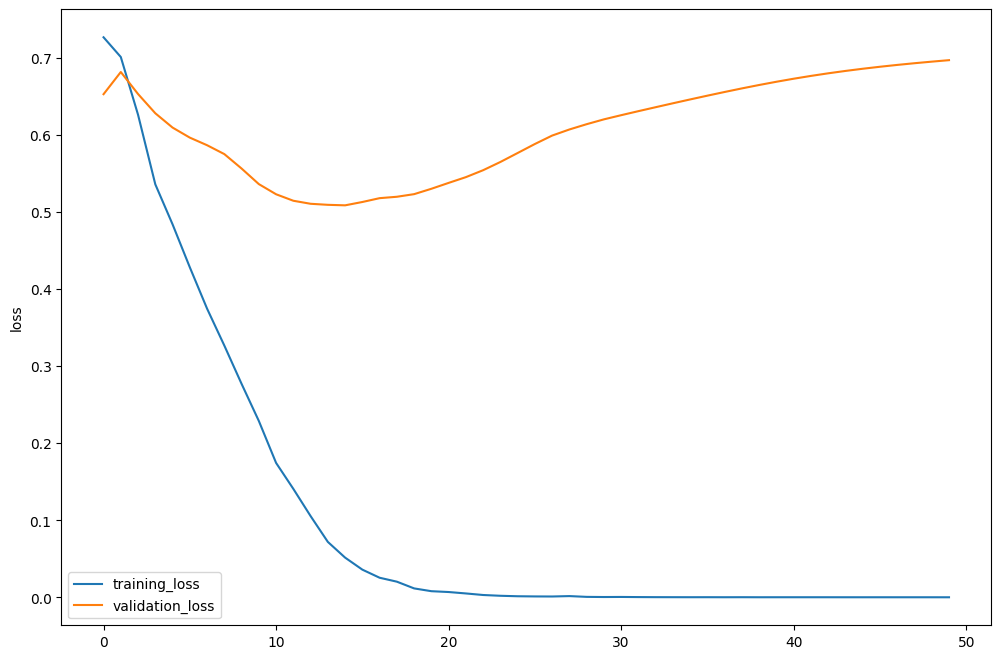

In [133]:
plt.figure(figsize=(12,8))
sns.lineplot(history['loss'], label="training_loss")
sns.lineplot(history['val_loss'], label="validation_loss")